In [2]:
import csv
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
LOGDIR = '../philly-traces/trace-data'
DATE_FORMAT_STR = '%Y-%m-%d %H:%M:%S'
MINUTES_PER_DAY = (24 * 60)
MICROSECONDS_PER_MINUTE = (60 * 1000)

In [4]:
def parse_date(date_str):
    """Parses a date string and returns a datetime object if possible.
    
       Args:
           date_str: A string representing a date.
        
       Returns:
           A datetime object if the input string could be successfully
           parsed, None otherwise.
    """
    if date_str is None or date_str == '' or date_str == 'None':
        return None
    return datetime.datetime.strptime(date_str, DATE_FORMAT_STR)

def timedelta_to_minutes(timedelta):
    """Converts a datetime timedelta object to minutes.
    
       Args:
           timedelta: The timedelta to convert.
           
       Returns:
           The number of minutes captured in the timedelta.
    """
    minutes = 0.0
    minutes += timedelta.days * MINUTES_PER_DAY
    minutes += timedelta.seconds / 60.0
    minutes += timedelta.microseconds / MICROSECONDS_PER_MINUTE
    return minutes

def round_to_nearest_minute(t):
    """Rounds a datetime object down to the nearest minute.
    
       Args:
           t: A datetime object.
           
        Returns:
            A new rounded down datetime object.
    """
    return t - datetime.timedelta(seconds=t.second, microseconds=t.microsecond)

def add_minute(t):
    """Adds a single minute to a datetime object.
    
       Args:
           t: A datetime object.
           
        Returns:
            A new datetime object with an additional minute.
    """
    return t + datetime.timedelta(seconds=60)

In [5]:
def get_cdf(data):
    """Returns the CDF of the given data.
    
       Args:
           data: A list of numerical values.
           
       Returns:
           An pair of lists (x, y) for plotting the CDF.
    """
    sorted_data = sorted(data)
    p = 100. * np.arange(len(sorted_data)) / (len(sorted_data) - 1)
    return sorted_data, p

In [6]:
class JobTrace:
    """Encapsulates a job."""
    
    def __init__(self, status, jobid, attempts, submitted_time, user):
        """Records job parameters and computes key metrics.
        
           Stores the passed in arguments as well as the number of GPUs
           requested by the job. In addition, computes the queueing delay
           as defined as the delta between the submission time and the start
           time of the first attempt. Finally, computes run time as defined
           as the delta between the initial attempt's start time and the last
           attempt's finish time.
           
           NOTE: Some jobs do not have any recorded attempts, and some attempts
           have missing start and/or end times. A job's latest attempt having no
           end time indicates that the job was still running when the log data
           was collected.
   
           Args:
               status: One of 'Pass', 'Killed', 'Failed'.
               jobid: The hash of the job id.
               attempts: A list of dicts, where each dict contains the following keys:
                   'start_time': The start time of the attempt.
                   'end_time': The end time of the attempt.
                   'detail': A list of nested dicts where each dict contains 
                             the following keys:
                        'ip': The server id.
                        'gpus': A list of the GPU ids allotted for this attempt.
                submitted_time: The time the job was submitted to the queue.
                user: The user's id.            
        """
        self._status = status
        self._jobid = jobid
        for attempt in attempts:
            attempt['start_time'] = parse_date(attempt['start_time'])
            attempt['end_time'] = parse_date(attempt['end_time'])
        self._attempts = attempts
        self._submitted_time = parse_date(submitted_time)
        self._user = user
        
        if len(self._attempts) == 0:
            self._num_gpus = None
            self._run_time = None
            self._queueing_delay = None
        else:
            self._num_gpus = sum([len(detail['gpus']) for detail in self._attempts[0]['detail']])
            if self._attempts[0]['start_time'] is None:
                self._run_time = None
                self._queueing_delay = None
            else:
                if self._attempts[-1]['end_time'] is None:
                    self._run_time = None
                else:
                    self._run_time = \
                        timedelta_to_minutes(self._attempts[-1]['end_time'] -
                                             self._attempts[0]['start_time'])
                self._queueing_delay = \
                    timedelta_to_minutes(self._attempts[0]['start_time'] -
                                         self._submitted_time)
    
    def __repr__(self):
        return (f'Job(job_id={self._jobid},\n'
                f'user={self._user},\n'
                f'status={self._status},\n'
                f'num_gpus = {self._num_gpus},\n'
                f'submitted_time = {self._submitted_time},\n'
                f'run_time={self._run_time}\n'
                f'attempts={self._attempts})')
    
    @property
    def status(self):
        return self._status
    
    @property
    def jobid(self):
        return self._jobid
    
    @property
    def attempts(self):
        return self._attempts
    
    @property
    def submitted_time(self):
        return self._submitted_time
    
    @property
    def user(self):
        return self._user
    
    @property
    def num_gpus(self):
        return self._num_gpus
    
    @property
    def queueing_delay(self):
        return self._queueing_delay
    
    @property
    def run_time(self):
        return self._run_time

In [7]:
def get_bucket_from_num_gpus(num_gpus):
    """Maps GPU count to a bucket for plotting purposes."""
    if num_gpus is None:
        return None
    if num_gpus == 1:
        return 0
    elif num_gpus >= 2 and num_gpus <= 4:
        return 1
    elif num_gpus >= 5 and num_gpus <= 8:
        return 2
    elif num_gpus > 8:
        return 3
    else:
        return None
    
def get_plot_config_from_bucket(bucket):
    """Returns plotting configuration information."""
    if bucket == 0:
        return ('1', 'green', '-')
    elif bucket == 1:
        return ('2-4', 'blue', '-.')
    elif bucket == 2:
        return ('5-8', 'red', '--')
    elif bucket == 3:
        return ('>8', 'purple', ':')

In [8]:
cluster_job_log_path = os.path.join(LOGDIR, 'cluster_job_log')
with open(cluster_job_log_path, 'r') as f:
    cluster_job_log = json.load(f)
jobs = [JobTrace(status=job['status'], jobid=job['jobid'], attempts=job['attempts'], submitted_time=job['submitted_time'], user=job['user']) for job in cluster_job_log]
jobs = sorted(jobs, key=lambda t: t._submitted_time)

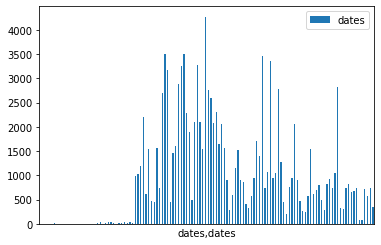

In [9]:
import pandas as pd
dates = [j._submitted_time.date() for j in jobs]
dates_df = pd.DataFrame (dates, columns = ['dates'])
dates_df["dates"] = dates_df["dates"].astype("datetime64")
dates_df.groupby([dates_df["dates"].dt.month, dates_df["dates"].dt.day]).count().plot(kind="bar")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

331


<AxesSubplot:xlabel='dates'>

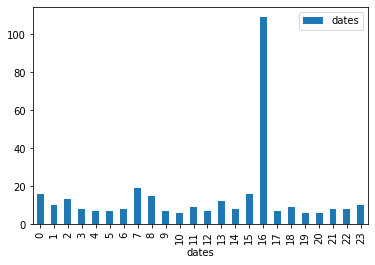

In [10]:
start_day = datetime.datetime(2017, 10, 7)
day_jobs = [j for j in jobs if (j._submitted_time - start_day).days ==0 and j._run_time is not None and j.status == 'Pass']
print(len(day_jobs))

dates = [j._submitted_time for j in day_jobs]
dates_df = pd.DataFrame (dates, columns = ['dates'])
dates_df["dates"] = dates_df["dates"].astype("datetime64")
dates_df.groupby([dates_df["dates"].dt.hour]).count().plot(kind="bar")


No handles with labels found to put in legend.


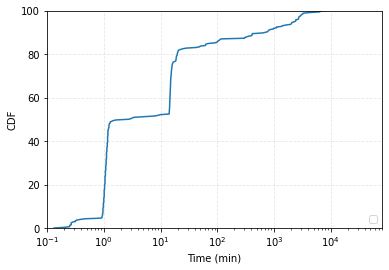

In [11]:
# Plotting Job CDF for Phillly Trace
dayrun_times = []
for j in day_jobs:
    if j._run_time is not None and j.status=='Pass':
        dayrun_times.append(j._run_time)
dayrun_times.sort()
#print(run_times)

# buckets = sorted([bucket for bucket in run_times])
# for bucket in buckets:
#     num_gpus, color, linestyle = get_plot_config_from_bucket(bucket)
x, y = get_cdf(dayrun_times)
plt.plot(x, y)
plt.legend(loc='lower right')
plt.xscale('log')
plt.xlim(10 ** -1, 8* 10 ** 4)
plt.ylim(0, 100)
plt.xlabel('Time (min)')
plt.ylabel('CDF')
plt.grid(alpha=.3, linestyle='--')
plt.show()

In [28]:
# Preprocessing
og_day_jobs = day_jobs
day_jobs = og_day_jobs[0:100]
print(len(day_jobs))
deadline_multiplier = 1.05
# Let's do everything in hours (for normalization sake)
starting_time = day_jobs[0]._submitted_time

dayjob_arrival_times = [(j._submitted_time- starting_time).seconds/3600.0 for j in day_jobs]


dayrun_times = []
for j in day_jobs:
    if j._run_time is not None and j.status=='Pass':
        dayrun_times.append(j._run_time)
dayjob_run_times = [j/60.0 for j in dayrun_times]
# Here jobs can only wait for at max 5% of its runtime
dayjob_dead_times = [dayjob_arrival_times[i] + deadline_multiplier * dayjob_run_times[i] for i, _ in enumerate(dayjob_run_times)]

num_nodes = 20

100


In [29]:
def fifo(arrival_times, run_times, dead_times, num_nodes):
    cloud_cost = 0.0
    # Indicates when occupying job on the onprem node will finish.
    node_open = [-1] * num_nodes
    for idx, a_time in enumerate(arrival_times):
        #print(node_open)
        # Remove from nodes if the current time > node_open
        for n_idx, n in enumerate(node_open):
            if n != -1 and a_time > n:
                # This means that job already finished
                node_open[n_idx]=-1
        found_node = False
        for n_idx, n in enumerate(node_open):
            if n==-1:
                node_open[n_idx] = a_time + run_times[idx]
                found_node = True
                break

        if found_node == False:
            cloud_cost += run_times[idx]
    return cloud_cost

def delayed_sched(arrival_times, run_times, dead_times, num_nodes):
    cloud_cost = 0.0
    # Indicates when occupying job on the onprem node will finish.
    node_open = [-1] * num_nodes
    list_times = list(enumerate(arrival_times.copy()))
    queue_times = []
    a_time = 0
    while queue_times or list_times:
#         print(node_open)
#         print(queue_times)
#         print()
        from_queue = False
        if queue_times:
            if list_times and list_times[0][1] < queue_times[0][1]:
                idx, a_time = list_times.pop(0)
            else:
                idx, a_time = queue_times.pop(0)
                from_queue = True
        else:
            idx, a_time = list_times.pop(0)
#         if not from_queue:
#             print(f"{a_time} + {run_times[idx]} -> ({dead_times[idx]})")
#         else:
#             print(f"{arrival_times[idx]} + {run_times[idx]} -> ({dead_times[idx]})")
        #print(node_open)
        # Remove from nodes if the current time > node_open
        for n_idx, n in enumerate(node_open):
            if n != -1 and a_time > n:
                # This means that job already finished
                node_open[n_idx]=-1
        
        
        found_node = False
        for n_idx, n in enumerate(node_open):
            if n==-1:
                node_open[n_idx] = a_time + run_times[idx]
                found_node = True
                break
        
        if found_node == False:
            if not from_queue:
                queue_times.append((idx, arrival_times[idx] + (dead_times[idx] - run_times[idx])))
            else:
                cloud_cost += run_times[idx]
        
        queue_times.sort(key = lambda a: a[1]) 
    return cloud_cost

print(fifo(dayjob_arrival_times, dayjob_run_times, dayjob_dead_times, num_nodes))

print(delayed_sched(dayjob_arrival_times, dayjob_run_times, dayjob_dead_times, num_nodes))

124.30499999999999
46.60722222222223


In [30]:
# Time for optimal MILP
def milp_solver_v1(arrival_times, run_times, dead_times, num_nodes):
    import cvxpy
    import numpy as np
    from multiprocessing import Pool
    num_jobs = len(run_times)
    
    arrival_times = np.array(arrival_times)
    run_times = np.array(run_times)
    dead_times = np.array(dead_times)
    
    selection = cvxpy.Variable((num_nodes, num_jobs), boolean=True)
    start_times = cvxpy.Variable((num_jobs, ))
    job_precedence = cvxpy.Variable((num_jobs, num_jobs), boolean=True)
    
    constraints = []
    
    bin_constraint = cvxpy.sum(selection, axis=0) <= 1
    constraints.append(bin_constraint)
    
    constraints.append(start_times >= arrival_times)
    
    constraints.append(start_times + run_times <= dead_times)
    
    for r in range(0, num_jobs):
        for j in range(r+1, num_jobs):
            constraints.append(start_times[j] - (start_times[r] + run_times[r]) + 1000000 * (2 + job_precedence[j][r] - selection[:,j] - selection[:,r]) >=0)
            constraints.append(start_times[r] - (start_times[j] + run_times[j]) + 1000000 * (3 - job_precedence[j][r] - selection[:,j] - selection[:,r]) >=0)

    # Our total utility is the sum of the item utilities
    total_utility = cvxpy.sum(selection@np.array(run_times).reshape((num_jobs, 1)))

    # We tell cvxpy that we want to maximize total utility 
    # subject to weight_constraint. All constraints in 
    # cvxpy must be passed as a list
    milp_problem = cvxpy.Problem(cvxpy.Maximize(total_utility), constraints)
    
    opts = {'limits/time' : 600} #{'maxiters' : 5000}
    milp_problem.solve(solver=cvxpy.SCIP, verbose=True, scip_params = opts)
    
    solution = selection.value
    total_weight = solution @ np.array(run_times).reshape((num_jobs, 1))
    print(np.sum(run_times) - np.sum(total_weight))
    return milp_problem, (selection, start_times, job_precedence)
asdf = milp_solver_v1(dayjob_arrival_times, dayjob_run_times, dayjob_dead_times, num_nodes)

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Jan 19 03:25:27 AM: Your problem has 12100 variables, 9903 constraints, and 0 parameters.
(CVXPY) Jan 19 03:25:30 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 19 03:25:30 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 19 03:25:30 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 19 03:25:32 AM: Compiling problem (target solver=SCIP).
(CVXPY) Jan 19 03:25:32 AM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -

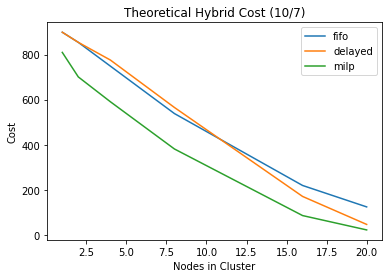

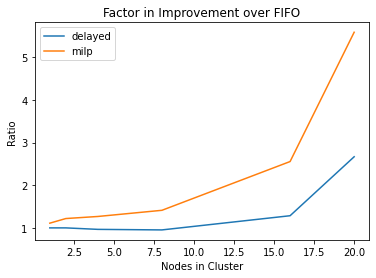

In [35]:
# 1
# 898.6872222222224
# 898.6872222222224
# 809.3183333333333

# 2
# 853.8433333333336
# 853.8433333333338
# 700.5619444444444

# 4
# 748.5313888888893
# 775.5086111111115
# 590.6227777777777

# 8
# 538.1697222222224
# 565.1294444444446
# 381.1455555555556

# 16
# 219.31416666666667
# 170.6811111111111
# 85.84388888888873

# 20
# 124.30499999999999
# 46.60722222222223
# 22.253888888888923

results = {1:{'fifo':898.6872222222224, 'delayed':898.6872222222224, 'milp':809.3183333333333}, 
           2:{'fifo':853.8433333333336, 'delayed':853.8433333333338, 'milp':700.5619444444444},
           4:{'fifo':748.5313888888893, 'delayed':775.5086111111115, 'milp':590.6227777777777},
           8:{'fifo':538.1697222222224, 'delayed':565.1294444444446, 'milp':381.1455555555556},
           16:{'fifo':219.31416666666667, 'delayed':170.6811111111111, 'milp':85.84388888888873},
           20:{'fifo':124.30499999999999, 'delayed':46.60722222222223, 'milp':22.253888888888923}}

x = [1,2,4,8,16,20]
for alg in ['fifo', 'delayed', 'milp']:
    y= []
    for clus in x:
        y.append(results[clus][alg])
    plt.plot(x, y, label = f"{alg}")
plt.xlabel('Nodes in Cluster')
plt.ylabel('Cost')
plt.legend()
plt.title('Theoretical Hybrid Cost (10/7)')
plt.show()


x = [1,2,4,8,16,20]
for alg in ['delayed', 'milp']:
    y= []
    for clus in x:
        y.append(results[clus]['fifo']/results[clus][alg])
    plt.plot(x, y, label = f"{alg}")
plt.xlabel('Nodes in Cluster')
plt.ylabel('Ratio')
plt.legend()
plt.title('Factor in Improvement over FIFO')
plt.show()

In [45]:
get_solutions(problem[0], problem[1], dayjob_run_times, timeout=60)

NameError: name 'day_job_run_times' is not defined